In [ ]:
from onnxruntime.quantization import quantize_dynamic, QuantType

# Path to the original float32 model
input_model_path = "/content/cnn_model.onnx"

# Path to save the quantized int8 model
output_model_path = "classifier_int8.onnx"

# Perform dynamic quantization
quantize_dynamic(
    model_input=input_model_path,
    model_output=output_model_path,
    weight_type=QuantType.QInt8  # Or QuantType.QUInt8 for unsigned
)

print("✅ Quantization complete. Saved to:", output_model_path)


✅ Quantization complete. Saved to: classifier_int8.onnx


In [ ]:
pip install onnxruntime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 358.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 709.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 615.6 kB/s eta 0:00:00


In [ ]:
pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 100.5 MB/s eta 0:00:00


In [ ]:
import onnx

model = onnx.load("/content/auto_int8.onnx")

# Check initializers (weights)
for tensor in model.graph.initializer:
    print(f"{tensor.name}: {onnx.TensorProto.DataType.Name(tensor.data_type)}")

# Optional: Check input/output types too
for input in model.graph.input:
    print(f"Input {input.name}: {input.type}")
for output in model.graph.output:
    print(f"Output {output.name}: {output.type}")


functional_1/conv2d_4_1/Squeeze:0: FLOAT
functional_1/conv2d_3_1/Squeeze:0: FLOAT
functional_1/conv2d_2_1/Squeeze:0: FLOAT
functional_1/conv2d_1_2/Squeeze:0: FLOAT
functional_1/conv2d_1/Squeeze:0: FLOAT
const_fold_opt__55__58: INT64
const_fold_opt__51: INT64
const_fold_opt__47: INT64
const_fold_opt__45: INT64
const_fold_opt__43__57: INT64
const_fold_opt__42: INT64
functional_1/conv2d_1/convolution/ReadVariableOp:0_scale: FLOAT
functional_1/conv2d_1/convolution/ReadVariableOp:0_zero_point: INT8
functional_1/conv2d_1/convolution/ReadVariableOp:0_quantized: INT8
functional_1/conv2d_1/BiasAdd:0_bias_reshape_shape: INT64
functional_1/conv2d_1_2/convolution/ReadVariableOp:0_scale: FLOAT
functional_1/conv2d_1_2/convolution/ReadVariableOp:0_zero_point: INT8
functional_1/conv2d_1_2/convolution/ReadVariableOp:0_quantized: INT8
functional_1/conv2d_1_2/BiasAdd:0_bias_reshape_shape: INT64
functional_1/conv2d_2_1/convolution/ReadVariableOp:0_scale: FLOAT
functional_1/conv2d_2_1/convolution/ReadVaria

In [ ]:
from onnxruntime.quantization import CalibrationDataReader
import numpy as np
import cv2
import os

class MyCalibrationDataReader(CalibrationDataReader):
    def __init__(self, image_dir, input_name):
        self.image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg'))]
        self.input_name = input_name
        self.data = []
        for img_path in self.image_paths:
            img = cv2.imread(img_path)
            img = cv2.resize(img, (64, 64))
            img = img.astype(np.float32) / 255.0  # adjust as per your normalization
            img = np.expand_dims(img, axis=0)
            self.data.append({self.input_name: img})
        self.idx = 0

    def get_next(self):
        if self.idx >= len(self.data):
            return None
        item = self.data[self.idx]
        self.idx += 1
        return item


In [ ]:
from onnxruntime.quantization import quantize_static, QuantType
import onnx

# Load ONNX model
model = onnx.load("/content/autoencoder_model.onnx")
input_name = model.graph.input[0].name

# Initialize reader
reader = MyCalibrationDataReader("path_to_sample_images", input_name)

quantize_static(
    model_input="/content/autoencoder_model.onnx",
    model_output="auto_static_int8.onnx",
    calibration_data_reader=reader,
    quant_format="QOperator",
    activation_type=QuantType.QInt8,
    weight_type=QuantType.QInt8,
    optimize_model=True
)


FileNotFoundError: [Errno 2] No such file or directory: 'path_to_sample_images'

In [ ]:
# 2. Unzip the dataset
import zipfile
import os

zip_path = '/content/onnx_.zip'         # <- Your zip file path
extract_path = '/content/onnx_calibration_images'       # <- Extract location

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted files:", os.listdir(extract_path)[:5])  # Print some filenames to check


Extracted files: ['onnx_']


In [ ]:
# Define the CalibrationDataReader
from onnxruntime.quantization import CalibrationDataReader
import numpy as np
import cv2

class MyCalibrationDataReader(CalibrationDataReader):
    def __init__(self, image_dir, input_name):
        self.image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg'))]
        self.input_name = input_name
        self.data = []
        for img_path in self.image_paths:
            img = cv2.imread(img_path)
            img = cv2.resize(img, (64, 64))
            img = img.astype(np.float32) / 255.0
            img = np.expand_dims(img, axis=0)   # add batch dim (NCHW)
            self.data.append({self.input_name: img})
        self.idx = 0

    def get_next(self):
        if self.idx >= len(self.data):
            return None
        item = self.data[self.idx]
        self.idx += 1
        return item


In [ ]:
# Perform Static Quantization
from onnxruntime.quantization import quantize_static, QuantType
import onnx

# Load the original ONNX model
model = onnx.load("/content/cnn_model.onnx")
input_name = model.graph.input[0].name

# Initialize calibration data reader
reader = MyCalibrationDataReader("/content/onnx_calibration_images/onnx_", input_name)

# Run quantization
quantize_static(
    model_input="/content/cnn_model.onnx",
    model_output="/content/classifier_static_int8.onnx",
    calibration_data_reader=reader,
    quant_format="QOperator",
    activation_type=QuantType.QInt8,
    weight_type=QuantType.QInt8
)


print("Quantized model saved as classifier_static_int8.onnx")


Quantized model saved as classifier_static_int8.onnx


In [ ]:

import onnx

model = onnx.load("/content/classifier_static_int8.onnx")

# Check initializers (weights)
for tensor in model.graph.initializer:
    print(f"{tensor.name}: {onnx.TensorProto.DataType.Name(tensor.data_type)}")

# Optional: Check input/output types too
for input in model.graph.input:
    print(f"Input {input.name}: {input.type}")
for output in model.graph.output:
    print(f"Output {output.name}: {output.type}")

const_fold_opt__77: INT64
sequential_1/conv2d_5_1/BiasAdd__64:0_zero_point: INT8
sequential_1/conv2d_5_1/BiasAdd__64:0_scale: FLOAT
sequential_1/conv2d_5_1/convolution/ReadVariableOp:0_zero_point: INT8
sequential_1/conv2d_5_1/convolution/ReadVariableOp:0_scale: FLOAT
sequential_1/conv2d_5_1/convolution/ReadVariableOp:0_quantized: INT8
sequential_1/conv2d_5_1/Relu:0_zero_point: INT8
sequential_1/conv2d_5_1/Relu:0_scale: FLOAT
sequential_1/conv2d_6_1/convolution/ReadVariableOp:0_zero_point: INT8
sequential_1/conv2d_6_1/convolution/ReadVariableOp:0_scale: FLOAT
sequential_1/conv2d_6_1/convolution/ReadVariableOp:0_quantized: INT8
sequential_1/conv2d_6_1/Relu:0_zero_point: INT8
sequential_1/conv2d_6_1/Relu:0_scale: FLOAT
sequential_1/conv2d_7_1/convolution/ReadVariableOp:0_zero_point: INT8
sequential_1/conv2d_7_1/convolution/ReadVariableOp:0_scale: FLOAT
sequential_1/conv2d_7_1/convolution/ReadVariableOp:0_quantized: INT8
sequential_1/conv2d_7_1/Relu:0_zero_point: INT8
sequential_1/conv2d_7

In [ ]:
import onnx

# Load the model
model_path = "/content/auto_int8.onnx"  # Change to your actual model path
model = onnx.load(model_path)

def inspect_operator_dtypes(model):
    fp32_nodes = []
    int32_nodes = []
    int8_nodes = []
    other_nodes = []

    for node in model.graph.node:
        # Convert protobuf containers to lists first
        input_names = list(node.input)
        output_names = list(node.output)
        all_names = input_names + output_names

        # Check for known type indicators in names (common with quantized models)
        if any("int8" in name.lower() for name in all_names):
            int8_nodes.append(node)
        elif any("int32" in name.lower() for name in all_names):
            int32_nodes.append(node)
        elif any("float" in name.lower() or "fp32" in name.lower() for name in all_names):
            fp32_nodes.append(node)
        else:
            other_nodes.append(node)

    print(f"🧠 FP32 nodes: {len(fp32_nodes)}")
    print(f"🧮 INT32 nodes: {len(int32_nodes)}")
    print(f"📦 INT8 nodes: {len(int8_nodes)}")
    print(f"❓ Other nodes: {len(other_nodes)}")

    print("\n🔍 Sample FP32 Ops:")
    for node in fp32_nodes[:10]:  # show just first 10
        print(f" - {node.op_type} (name: {node.name})")

inspect_operator_dtypes(model)

🧠 FP32 nodes: 0
🧮 INT32 nodes: 0
📦 INT8 nodes: 0
❓ Other nodes: 60

🔍 Sample FP32 Ops:


In [ ]:
pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 100.3 MB/s eta 0:00:00


In [ ]:
import onnx

# Load the model
model_path = "/content/classifier_int8.onnx"  # Change to your actual model path
model = onnx.load(model_path)

def inspect_operator_dtypes(model):
    fp32_nodes = []
    int32_nodes = []
    int8_nodes = []
    other_nodes = []

    for node in model.graph.node:
        # Convert protobuf containers to lists first
        input_names = list(node.input)
        output_names = list(node.output)
        all_names = input_names + output_names

        # Check for known type indicators in names (common with quantized models)
        if any("int8" in name.lower() for name in all_names):
            int8_nodes.append(node)
        elif any("int32" in name.lower() for name in all_names):
            int32_nodes.append(node)
        elif any("float" in name.lower() or "fp32" in name.lower() for name in all_names):
            fp32_nodes.append(node)
        else:
            other_nodes.append(node)

    print(f"🧠 FP32 nodes: {len(fp32_nodes)}")
    print(f"🧮 INT32 nodes: {len(int32_nodes)}")
    print(f"📦 INT8 nodes: {len(int8_nodes)}")
    print(f"❓ Other nodes: {len(other_nodes)}")

    print("\n🔍 Sample FP32 Ops:")
    for node in fp32_nodes[:10]:  # show just first 10
        print(f" - {node.op_type} (name: {node.name})")

inspect_operator_dtypes(model)

🧠 FP32 nodes: 0
🧮 INT32 nodes: 0
📦 INT8 nodes: 0
❓ Other nodes: 44

🔍 Sample FP32 Ops:


In [ ]:
import onnx

# Load the model
model_path = "/content/auto_static_int8.onnx"  # Change to your actual model path
model = onnx.load(model_path)

def inspect_operator_dtypes(model):
    fp32_nodes = []
    int32_nodes = []
    int8_nodes = []
    other_nodes = []

    for node in model.graph.node:
        # Convert protobuf containers to lists first
        input_names = list(node.input)
        output_names = list(node.output)
        all_names = input_names + output_names

        # Check for known type indicators in names (common with quantized models)
        if any("int8" in name.lower() for name in all_names):
            int8_nodes.append(node)
        elif any("int32" in name.lower() for name in all_names):
            int32_nodes.append(node)
        elif any("float" in name.lower() or "fp32" in name.lower() for name in all_names):
            fp32_nodes.append(node)
        else:
            other_nodes.append(node)

    print(f"🧠 FP32 nodes: {len(fp32_nodes)}")
    print(f"🧮 INT32 nodes: {len(int32_nodes)}")
    print(f"📦 INT8 nodes: {len(int8_nodes)}")
    print(f"❓ Other nodes: {len(other_nodes)}")

    print("\n🔍 Sample FP32 Ops:")
    for node in fp32_nodes[:10]:  # show just first 10
        print(f" - {node.op_type} (name: {node.name})")

inspect_operator_dtypes(model)

🧠 FP32 nodes: 0
🧮 INT32 nodes: 0
📦 INT8 nodes: 0
❓ Other nodes: 64

🔍 Sample FP32 Ops:


In [ ]:
import onnx
from onnx import mapping

model_path = "/content/auto_int8.onnx"
model = onnx.load(model_path)

def dtype_str(tensor_type):
    """Return the data type name from ONNX tensor type enum."""
    return mapping.TENSOR_TYPE_TO_NP_TYPE.get(tensor_type, "UNKNOWN")

def print_tensor_dtypes(model):
    all_tensors = (
        list(model.graph.initializer) +
        list(model.graph.input) +
        list(model.graph.output) +
        list(model.graph.value_info)
    )

    dtype_counts = {}
    for tensor in all_tensors:
        try:
            # Handle initializer differently
            if hasattr(tensor, 'data_type'):
                dtype = tensor.data_type
            else:
                dtype = tensor.type.tensor_type.elem_type
        except:
            continue

        dtype_name = dtype_str(dtype)
        dtype_counts[dtype_name] = dtype_counts.get(dtype_name, 0) + 1

    print("📊 Tensor Data Type Counts:")
    for dtype, count in dtype_counts.items():
        print(f" - {dtype}: {count}")

print_tensor_dtypes(model)

📊 Tensor Data Type Counts:
 - float32: 41
 - int64: 11
 - int8: 10


In [ ]:
import onnx
from onnx import mapping

model_path = "/content/auto_static_int8.onnx"
model = onnx.load(model_path)

def dtype_str(tensor_type):
    """Return the data type name from ONNX tensor type enum."""
    return mapping.TENSOR_TYPE_TO_NP_TYPE.get(tensor_type, "UNKNOWN")

def print_tensor_dtypes(model):
    all_tensors = (
        list(model.graph.initializer) +
        list(model.graph.input) +
        list(model.graph.output) +
        list(model.graph.value_info)
    )

    dtype_counts = {}
    for tensor in all_tensors:
        try:
            # Handle initializer differently
            if hasattr(tensor, 'data_type'):
                dtype = tensor.data_type
            else:
                dtype = tensor.type.tensor_type.elem_type
        except:
            continue

        dtype_name = dtype_str(dtype)
        dtype_counts[dtype_name] = dtype_counts.get(dtype_name, 0) + 1

    print("📊 Tensor Data Type Counts:")
    for dtype, count in dtype_counts.items():
        print(f" - {dtype}: {count}")

print_tensor_dtypes(model)

📊 Tensor Data Type Counts:
 - int64: 6
 - int8: 19
 - float32: 50
 - int32: 10


In [ ]:
import onnx
from onnx import mapping

model_path = "/content/classifier_int8.onnx"
model = onnx.load(model_path)

def dtype_str(tensor_type):
    """Return the data type name from ONNX tensor type enum."""
    return mapping.TENSOR_TYPE_TO_NP_TYPE.get(tensor_type, "UNKNOWN")

def print_tensor_dtypes(model):
    all_tensors = (
        list(model.graph.initializer) +
        list(model.graph.input) +
        list(model.graph.output) +
        list(model.graph.value_info)
    )

    dtype_counts = {}
    for tensor in all_tensors:
        try:
            # Handle initializer differently
            if hasattr(tensor, 'data_type'):
                dtype = tensor.data_type
            else:
                dtype = tensor.type.tensor_type.elem_type
        except:
            continue

        dtype_name = dtype_str(dtype)
        dtype_counts[dtype_name] = dtype_counts.get(dtype_name, 0) + 1

    print("📊 Tensor Data Type Counts:")
    for dtype, count in dtype_counts.items():
        print(f" - {dtype}: {count}")

print_tensor_dtypes(model)

📊 Tensor Data Type Counts:
 - float32: 29
 - int64: 4
 - int8: 10


In [ ]:
import onnx
from onnx import mapping

model_path = "/content/classifier_static_int8.onnx"
model = onnx.load(model_path)

def dtype_str(tensor_type):
    """Return the data type name from ONNX tensor type enum."""
    return mapping.TENSOR_TYPE_TO_NP_TYPE.get(tensor_type, "UNKNOWN")

def print_tensor_dtypes(model):
    all_tensors = (
        list(model.graph.initializer) +
        list(model.graph.input) +
        list(model.graph.output) +
        list(model.graph.value_info)
    )

    dtype_counts = {}
    for tensor in all_tensors:
        try:
            # Handle initializer differently
            if hasattr(tensor, 'data_type'):
                dtype = tensor.data_type
            else:
                dtype = tensor.type.tensor_type.elem_type
        except:
            continue

        dtype_name = dtype_str(dtype)
        dtype_counts[dtype_name] = dtype_counts.get(dtype_name, 0) + 1

    print("📊 Tensor Data Type Counts:")
    for dtype, count in dtype_counts.items():
        print(f" - {dtype}: {count}")

print_tensor_dtypes(model)

📊 Tensor Data Type Counts:
 - int64: 1
 - int8: 17
 - float32: 34
 - int32: 10


In [ ]:
import os
import zipfile
import numpy as np
import onnxruntime as ort
import psutil
import logging
from PIL import Image
import time
import matplotlib.pyplot as plt
from memory_profiler import memory_usage
from sklearn.metrics import accuracy_score

# Suppress logging
logging.getLogger('onnxruntime').setLevel(logging.ERROR)

# Define label dictionary (example)
label_dict = {0: "arm", 1: "elbow", 2: "face", 3: "foot", 4: "hand", 5: "leg", 6: "random"}

# Paths to your models
onnx_original = "/content/cnn_model.onnx"
onnx_quantized = "/content/classifier_int8.onnx"

# Helper to unzip folder
def unzip_folder(zip_path, extract_to="dataset"):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    return extract_to

# Preprocess image (resize and normalize)
def preprocess_image(image_path, size=(64, 64)):
    img = Image.open(image_path).convert("RGB").resize(size)
    img = np.array(img, dtype=np.float32) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Run inference on ONNX model
def run_onnx_inference(session, input_data):
    input_name = session.get_inputs()[0].name
    outputs = session.run(None, {input_name: input_data})
    return outputs[0]

# Measure inference time, RAM, and CPU usage
def measure_inference(func, *args):
    process = psutil.Process()
    start_time = time.time()
    start_cpu = process.cpu_percent(interval=None)
    mem_usage = memory_usage((func, args), interval=0.1, max_usage=True)
    result = func(*args)
    end_time = time.time()
    end_cpu = process.cpu_percent(interval=None)
    exec_time = (end_time - start_time) * 1000  # milliseconds
    normalized_cpu = ((end_cpu + start_cpu) / 2) / psutil.cpu_count()
    return mem_usage, normalized_cpu, exec_time, result

# Load ONNX models
def create_session(model_path):
    try:
        return ort.InferenceSession(model_path, providers=['CPUExecutionProvider'])
    except Exception as e:
        print(f"Failed to load model: {e}")
        exit(1)

sess_orig = create_session(onnx_original)
sess_quant = create_session(onnx_quantized)

# Load image paths from unzipped folder
def load_images_from_folder(folder):
    images = []
    labels = []  # You should provide corresponding labels for the images
    for filename in os.listdir(folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(folder, filename)
            images.append(image_path)
            label = int(filename.split("_")[0])  # Assuming label is part of filename (e.g., "0_arm.jpg")
            labels.append(label)
    return images, labels

# Load images from folder
zip_path = "/content/onnx_.zip"  # Replace with your zip file path
dataset_folder = unzip_folder(zip_path)
image_paths, true_labels = load_images_from_folder(dataset_folder)

# Inference and evaluation
def evaluate_model(model_session, image_paths, true_labels):
    preds = []
    for img_path in image_paths:
        img_data = preprocess_image(img_path)
        pred = run_onnx_inference(model_session, img_data)
        preds.append(np.argmax(pred))  # Predicted class
    return accuracy_score(true_labels, preds)

# Evaluate original and quantized models
print("Evaluating Original Model...")
accuracy_orig = evaluate_model(sess_orig, image_paths, true_labels)
print(f"Original Model Accuracy: {accuracy_orig * 100:.2f}%")

print("Evaluating Quantized Model...")
accuracy_quant = evaluate_model(sess_quant, image_paths, true_labels)
print(f"Quantized Model Accuracy: {accuracy_quant * 100:.2f}%")

# Inference metrics for both models
def inference_metrics():
    print("\nOriginal Model Inference Metrics:")
    try:
        mem_orig, cpu_orig, time_orig, pred_orig = measure_inference(inference_original)
        print(f"  RAM={mem_orig:.2f} MB, CPU={cpu_orig:.2f}%, Time={time_orig:.2f} ms")
    except Exception as e:
        print(f"  Failed: {str(e)}")
        exit(1)

    print("\nQuantized Model Inference Metrics:")
    try:
        mem_quant, cpu_quant, time_quant, pred_quant = measure_inference(inference_quantized)
        print(f"  RAM={mem_quant:.2f} MB, CPU={cpu_quant:.2f}%, Time={time_quant:.2f} ms")
    except Exception as e:
        print(f"  Failed: {str(e)}")
        exit(1)

# Plot some examples (show original and predicted labels)
def plot_results(image_paths, true_labels, preds):
    plt.figure(figsize=(12, 6))
    for i in range(5):  # Show 5 examples
        plt.subplot(1, 5, i+1)
        img = Image.open(image_paths[i])
        plt.imshow(img)
        plt.title(f"True: {label_dict[true_labels[i]]}\nPred: {label_dict[preds[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage of plotting the results for 5 images
plot_results(image_paths, true_labels, preds)

Failed to load model: [ONNXRuntimeError] : 9 : NOT_IMPLEMENTED : Could not find an implementation for ConvInteger(10) node with name 'sequential_1/conv2d_5_1/BiasAdd_quant'
Evaluating Original Model...
Original Model Accuracy: nan%
Evaluating Quantized Model...
Quantized Model Accuracy: nan%


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NameError: name 'preds' is not defined

In [ ]:
pip install memory_profiler

In [ ]:
import os
import zipfile
import numpy as np
import onnxruntime as ort
from sklearn.metrics import accuracy_score
from PIL import Image

# Define label dictionary (example)
label_dict = {0: "arm", 1: "elbow", 2: "face", 3: "foot", 4: "hand", 5: "leg", 6: "random"}

# Paths to your models
onnx_original = "/content/cnn_model.onnx"
onnx_quantized = "/content/classifier_static_int8.onnx"

# Helper to unzip folder
def unzip_folder(zip_path, extract_to="dataset"):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    return extract_to

# Preprocess image (resize and normalize)
def preprocess_image(image_path, size=(64, 64)):
    img = Image.open(image_path).convert("RGB").resize(size)
    img = np.array(img, dtype=np.float32) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Run inference on ONNX model
def run_onnx_inference(session, input_data):
    input_name = session.get_inputs()[0].name
    outputs = session.run(None, {input_name: input_data})
    return outputs[0]

# Load ONNX models
def create_session(model_path):
    try:
        return ort.InferenceSession(model_path, providers=['CPUExecutionProvider'])
    except Exception as e:
        print(f"Failed to load model: {e}")
        exit(1)

sess_orig = create_session(onnx_original)
sess_quant = create_session(onnx_quantized)

# Load image paths from unzipped folder
def load_images_from_folder(folder):
    images = []
    labels = []  # You should provide corresponding labels for the images
    for filename in os.listdir(folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(folder, filename)
            images.append(image_path)
            label = int(filename.split("_")[0])  # Assuming label is part of filename (e.g., "0_arm.jpg")
            labels.append(label)
    return images, labels

# Load images from folder
zip_path = "/content/onnx_.zip"  # Replace with your zip file path
dataset_folder = unzip_folder(zip_path)
image_paths, true_labels = load_images_from_folder(dataset_folder)

# Evaluate model accuracy
def evaluate_model(model_session, image_paths, true_labels):
    preds = []
    for img_path in image_paths:
        img_data = preprocess_image(img_path)
        pred = run_onnx_inference(model_session, img_data)
        preds.append(np.argmax(pred))  # Predicted class
    accuracy = accuracy_score(true_labels, preds)
    return accuracy

# Evaluate original and quantized models
print("Evaluating Original Model...")
accuracy_orig = evaluate_model(sess_orig, image_paths, true_labels)
print(f"Original Model Accuracy: {accuracy_orig * 100:.2f}%")

print("Evaluating Quantized Model...")
accuracy_quant = evaluate_model(sess_quant, image_paths, true_labels)
print(f"Quantized Model Accuracy: {accuracy_quant * 100:.2f}%")

Evaluating Original Model...
Original Model Accuracy: nan%
Evaluating Quantized Model...
Quantized Model Accuracy: nan%


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
import os
import zipfile
import numpy as np
import onnxruntime as ort
from sklearn.metrics import accuracy_score
from PIL import Image

# Define label dictionary (example)
label_dict = {0: "arm", 1: "elbow", 2: "face", 3: "foot", 4: "hand", 5: "leg", 6: "random"}

# Paths to your models
onnx_original = "/content/cnn_model.onnx"
onnx_quantized = "/content/classifier_static_int8.onnx"

# Helper to unzip folder
def unzip_folder(zip_path, extract_to="dataset"):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    return extract_to

# Preprocess image (resize and normalize)
def preprocess_image(image_path, size=(64, 64)):
    img = Image.open(image_path).convert("RGB").resize(size)
    img = np.array(img, dtype=np.float32) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Run inference on ONNX model
def run_onnx_inference(session, input_data):
    input_name = session.get_inputs()[0].name
    outputs = session.run(None, {input_name: input_data})
    return outputs[0]

# Load ONNX models
def create_session(model_path):
    try:
        return ort.InferenceSession(model_path, providers=['CPUExecutionProvider'])
    except Exception as e:
        print(f"Failed to load model: {e}")
        exit(1)

sess_orig = create_session(onnx_original)
sess_quant = create_session(onnx_quantized)

# Load image paths and labels from unzipped folder
def load_images_from_folder(folder):
    images = []
    labels = []  # Labels are assigned based on subfolder names (e.g., '0_arm')
    class_labels = {cls: idx for idx, cls in label_dict.items()}

    for class_name in os.listdir(folder):
        class_folder = os.path.join(folder, class_name)

        if os.path.isdir(class_folder):
            for filename in os.listdir(class_folder):
                if filename.endswith(".jpg") or filename.endswith(".png"):
                    image_path = os.path.join(class_folder, filename)
                    images.append(image_path)
                    label = class_labels[class_name]  # Use folder name to assign label
                    labels.append(label)

    return images, labels

# Load images from folder
zip_path = "/content/natural_images.zip"  # Replace with your zip file path
dataset_folder = unzip_folder(zip_path)
image_paths, true_labels = load_images_from_folder(dataset_folder)

# Debug: Print out number of images and labels
print(f"Loaded {len(image_paths)} images.")
print(f"Loaded {len(true_labels)} labels.")

# Evaluate model accuracy
def evaluate_model(model_session, image_paths, true_labels):
    preds = []
    for img_path in image_paths:
        img_data = preprocess_image(img_path)
        pred = run_onnx_inference(model_session, img_data)

        # Debug: Check model output
        print(f"Prediction for {img_path}: {pred}")

        preds.append(np.argmax(pred))  # Predicted class

    # Debug: Check predictions and true labels
    print(f"Predictions: {preds}")
    print(f"True Labels: {true_labels}")

    accuracy = accuracy_score(true_labels, preds)
    return accuracy

# Evaluate original and quantized models
print("Evaluating Original Model...")
accuracy_orig = evaluate_model(sess_orig, image_paths, true_labels)
print(f"Original Model Accuracy: {accuracy_orig * 100:.2f}%")

print("Evaluating Quantized Model...")
accuracy_quant = evaluate_model(sess_quant, image_paths, true_labels)
print(f"Quantized Model Accuracy: {accuracy_quant * 100:.2f}%")

KeyError: 'onnx_'

In [ ]:
import os
import zipfile
import numpy as np
import onnxruntime as ort
from sklearn.metrics import accuracy_score
from PIL import Image

# Define label dictionary (example)
label_dict = {0: "arm", 1: "elbow", 2: "face", 3: "foot", 4: "hand", 5: "leg", 6: "random"}

# Paths to your models
onnx_original = "/content/cnn_model.onnx"
onnx_quantized = "/content/classifier_int8.onnx"

# Helper to unzip folder
def unzip_folder(zip_path, extract_to="dataset"):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    return extract_to

# Preprocess image (resize and normalize)
def preprocess_image(image_path, size=(64, 64)):
    img = Image.open(image_path).convert("RGB").resize(size)
    img = np.array(img, dtype=np.float32) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Run inference on ONNX model
def run_onnx_inference(session, input_data):
    input_name = session.get_inputs()[0].name
    outputs = session.run(None, {input_name: input_data})
    return outputs[0]

# Load ONNX models
def create_session(model_path):
    try:
        return ort.InferenceSession(model_path, providers=['CPUExecutionProvider'])
    except Exception as e:
        print(f"Failed to load model: {e}")
        exit(1)

sess_orig = create_session(onnx_original)
sess_quant = create_session(onnx_quantized)

# Load image paths and labels from unzipped folder
def load_images_from_folder(folder):
    images = []
    labels = []  # Labels are assigned based on subfolder names (e.g., '0_arm')
    class_labels = {cls: idx for idx, cls in label_dict.items()}

    # Debug: Print out all folders inside the dataset
    print(f"Found folders: {os.listdir(folder)}")

    for class_name in os.listdir(folder):
        class_folder = os.path.join(folder, class_name)

        # Check if the folder is a directory and if it belongs to the label dictionary
        if os.path.isdir(class_folder):
            if class_name in class_labels:
                print(f"Processing class: {class_name}")
                for filename in os.listdir(class_folder):
                    if filename.endswith(".jpg") or filename.endswith(".png"):
                        image_path = os.path.join(class_folder, filename)
                        images.append(image_path)
                        label = class_labels[class_name]  # Use folder name to assign label
                        labels.append(label)
            else:
                print(f"Skipping unknown class folder: {class_name}")

    return images, labels

# Load images from folder
zip_path = "/content/natural_images.zip"  # Replace with your zip file path
dataset_folder = unzip_folder(zip_path)
image_paths, true_labels = load_images_from_folder(dataset_folder)

# Debug: Print out number of images and labels
print(f"Loaded {len(image_paths)} images.")
print(f"Loaded {len(true_labels)} labels.")

# Evaluate model accuracy
def evaluate_model(model_session, image_paths, true_labels):
    preds = []
    for img_path in image_paths:
        img_data = preprocess_image(img_path)
        pred = run_onnx_inference(model_session, img_data)

        # Debug: Check model output
        print(f"Prediction for {img_path}: {pred}")

        preds.append(np.argmax(pred))  # Predicted class

    # Debug: Check predictions and true labels
    print(f"Predictions: {preds}")
    print(f"True Labels: {true_labels}")

    accuracy = accuracy_score(true_labels, preds)
    return accuracy

# Evaluate original and quantized models
print("Evaluating Original Model...")
accuracy_orig = evaluate_model(sess_orig, image_paths, true_labels)
print(f"Original Model Accuracy: {accuracy_orig * 100:.2f}%")

print("Evaluating Quantized Model...")
accuracy_quant = evaluate_model(sess_quant, image_paths, true_labels)
print(f"Quantized Model Accuracy: {accuracy_quant * 100:.2f}%")

Failed to load model: [ONNXRuntimeError] : 9 : NOT_IMPLEMENTED : Could not find an implementation for ConvInteger(10) node with name 'sequential_1/conv2d_5_1/BiasAdd_quant'
Found folders: ['natural_images', 'onnx_']
Skipping unknown class folder: natural_images
Skipping unknown class folder: onnx_
Loaded 0 images.
Loaded 0 labels.
Evaluating Original Model...
Predictions: []
True Labels: []
Original Model Accuracy: nan%
Evaluating Quantized Model...
Predictions: []
True Labels: []
Quantized Model Accuracy: nan%


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [5]:
import onnxruntime as rt

sess_options = rt.SessionOptions()

# Set graph optimization level
sess_options.graph_optimization_level = rt.GraphOptimizationLevel.ORT_ENABLE_EXTENDED

# To enable model serialization after graph optimization set this
sess_options.optimized_model_filepath = "/content/cnn_model.onnx"

session = rt.InferenceSession("/content/cnn_model.onnx", sess_options)


In [12]:
import onnx
import onnxruntime as rt

# Paths
original_model_path = "/content/autoencoder_model.onnx"  # Replace with your actual ONNX file path
optimized_model_path = "/content/autoencoder_model.onnx"  # Use forward slashes

# 🔹 Step 1: Count nodes WITHOUT optimization
original_model = onnx.load(original_model_path)
original_node_count = len(original_model.graph.node)
print(f"🔸 Original model node count: {original_node_count}")

# 🔹 Step 2: Set optimization options
sess_options = rt.SessionOptions()
sess_options.graph_optimization_level = rt.GraphOptimizationLevel.ORT_ENABLE_EXTENDED
sess_options.optimized_model_filepath = optimized_model_path

# 🔹 Step 3: Load and optimize model
session = rt.InferenceSession(original_model_path, sess_options)

# 🔹 Step 4: Count nodes in optimized model
optimized_model = onnx.load(optimized_model_path)
optimized_node_count = len(optimized_model.graph.node)
print(f"✅ Optimized model node count: {optimized_node_count}")


🔸 Original model node count: 30
✅ Optimized model node count: 23


In [13]:
import onnx
import onnxruntime as rt

# Paths
original_model_path = "/content/auto_16.onnx"  # Replace with your actual ONNX file path
optimized_model_path = "/content/auto_16.onnx"  # Use forward slashes

# 🔹 Step 1: Count nodes WITHOUT optimization
original_model = onnx.load(original_model_path)
original_node_count = len(original_model.graph.node)
print(f"🔸 Original model node count: {original_node_count}")

# 🔹 Step 2: Set optimization options
sess_options = rt.SessionOptions()
sess_options.graph_optimization_level = rt.GraphOptimizationLevel.ORT_ENABLE_EXTENDED
sess_options.optimized_model_filepath = optimized_model_path

# 🔹 Step 3: Load and optimize model
session = rt.InferenceSession(original_model_path, sess_options)

# 🔹 Step 4: Count nodes in optimized model
optimized_model = onnx.load(optimized_model_path)
optimized_node_count = len(optimized_model.graph.node)
print(f"✅ Optimized model node count: {optimized_node_count}")


🔸 Original model node count: 30
✅ Optimized model node count: 48


In [7]:
pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 51.1 MB/s eta 0:00:00


In [ ]:

# Step 2: Imports
import onnx
import onnxruntime as rt


# Get uploaded model filename
optimized_model_path = "/content/optimized_model.onnx"

# Step 4: Count nodes in a model
def count_nodes(path):
    model = onnx.load(path)
    return len(model.graph.node)

print(f"🔹 Original model node count: {count_nodes(model_path)}")

# Step 5: Optimize model using ONNX Runtime
sess_options = rt.SessionOptions()
sess_options.graph_optimization_level = rt.GraphOptimizationLevel.ORT_ENABLE_EXTENDED
sess_options.optimized_model_filepath = optimized_model_path

# Load the model with optimization
session = rt.InferenceSession(model_path, sess_options)

# Step 6: Count nodes after optimization
print(f"✅ Optimized model saved to: {optimized_model_path}")
print(f"🔸 Optimized model node count: {count_nodes(optimized_model_path)}")

# Step 7: Optionally download the optimized model
files.download(optimized_model_path)


In [15]:
!pip install onnxruntime
!pip install psutil
!pip install memory-profiler
!pip install numpy
!pip install pillow
!pip install matplotlib


ONNX Storage (MB):
AUTOENCODER: 0.29
CNN: 16.38

Autoencoder Inference Metrics (RAM in MB, CPU %, Execution Time in ms):
  RAM=228.22, CPU=12.93%, Time=154.70ms

? Denoised image saved: denoised_output_onnx.jpg
CNN Inference Metrics (RAM in MB, CPU %, Execution Time in ms):
  RAM=228.70, CPU=11.82%, Time=147.84ms

? Predicted Class: face (Class 2)


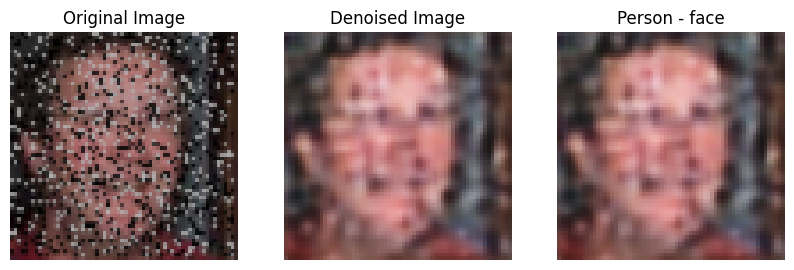

In [16]:
import os
import time
import numpy as np
import psutil
import onnxruntime as ort
from PIL import Image
import matplotlib.pyplot as plt
from memory_profiler import memory_usage

# Helper function to get storage size
def get_storage_size(file_path):
    if not os.path.exists(file_path):
        return 0.0
    return os.path.getsize(file_path) / (1024 * 1024)  # Size in MB

# Preprocess image
def preprocess_image(image_path, target_size=(64, 64)):
    img = Image.open(image_path).convert("RGB").resize(target_size)
    img = np.array(img, dtype=np.float32) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Helper function to measure inference
def measure_inference(func, *args):
    process = psutil.Process()
    start_time = time.time()
    start_cpu = process.cpu_percent(interval=None)
    mem_usage = memory_usage((func, args), interval=0.1, max_usage=True)
    result = func(*args)
    end_time = time.time()
    end_cpu = process.cpu_percent(interval=None)
    exec_time = (end_time - start_time) * 1000  # ms
    normalized_cpu = ((end_cpu + start_cpu) / 2) / psutil.cpu_count()  # Normalized to 0-100% of total capacity
    return mem_usage, normalized_cpu, exec_time, result

# Model and image paths
autoencoder_path = "/content/autoencoder_model.onnx"
cnn_path = "/content/cnn_model.onnx"
input_image_path = "/content/test2.jpg"

# Label dictionary
label_dict = {0: "arm", 1: "elbow", 2: "face", 3: "foot", 4: "hand", 5: "leg", 6: "random"}

# Check storage
print("ONNX Storage (MB):")
print(f"AUTOENCODER: {get_storage_size(autoencoder_path):.2f}")
print(f"CNN: {get_storage_size(cnn_path):.2f}")
print()

# Load models
try:
    autoencoder_session = ort.InferenceSession(autoencoder_path, providers=['CPUExecutionProvider'])
    cnn_session = ort.InferenceSession(cnn_path, providers=['CPUExecutionProvider'])
    autoencoder_input_name = autoencoder_session.get_inputs()[0].name
    cnn_input_name = cnn_session.get_inputs()[0].name
except Exception as e:
    print(f"Failed to load models: {str(e)}")
    exit(1)

# Load image
try:
    input_image = preprocess_image(input_image_path)
except Exception as e:
    print(f"Failed to load image: {str(e)}")
    exit(1)

# Step 1: Denoising with Autoencoder
def autoencoder_inference():
    return autoencoder_session.run(None, {autoencoder_input_name: input_image})[0]

print("Autoencoder Inference Metrics (RAM in MB, CPU %, Execution Time in ms):")
try:
    auto_mem, auto_cpu, auto_time, denoised_image = measure_inference(autoencoder_inference)
    print(f"  RAM={auto_mem:.2f}, CPU={auto_cpu:.2f}%, Time={auto_time:.2f}ms")
except Exception as e:
    print(f"  Failed: {str(e)}")
    exit(1)
print()

# Convert output to image format
denoised_image = (denoised_image[0] * 255).astype(np.uint8)
denoised_pil = Image.fromarray(denoised_image)
denoised_pil.save("denoised_output_onnx.jpg")
print("? Denoised image saved: denoised_output_onnx.jpg")

# Step 2: Classification using CNN
def cnn_inference():
    denoised_input = denoised_image.astype(np.float32) / 255.0
    denoised_input = np.expand_dims(denoised_input, axis=0)
    return cnn_session.run(None, {cnn_input_name: denoised_input})[0]

print("CNN Inference Metrics (RAM in MB, CPU %, Execution Time in ms):")
try:
    cnn_mem, cnn_cpu, cnn_time, predictions = measure_inference(cnn_inference)
    print(f"  RAM={cnn_mem:.2f}, CPU={cnn_cpu:.2f}%, Time={cnn_time:.2f}ms")
except Exception as e:
    print(f"  Failed: {str(e)}")
    exit(1)
print()

# Get predicted class
predicted_class = np.argmax(predictions)
predicted_label = label_dict.get(predicted_class, "Unknown")
print(f"? Predicted Class: {predicted_label} (Class {predicted_class})")

# Plot results
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(input_image))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(denoised_pil)
plt.title("Denoised Image")
plt.axis('off')

display_text = "No person found" if predicted_label.lower() == "random" else f"Person - {predicted_label}"

plt.subplot(1, 3, 3)
plt.imshow(denoised_pil)
plt.title(display_text)
plt.axis('off')

plt.show()

ONNX Storage (MB):
AUTOENCODER: 0.16
CNN: 8.19

Autoencoder Inference Metrics (RAM in MB, CPU %, Execution Time in ms):
  Failed: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Unexpected input data type. Actual: (tensor(float)) , expected: (tensor(float16))

? Denoised image saved: denoised_output_onnx.jpg
CNN Inference Metrics (RAM in MB, CPU %, Execution Time in ms):
  Failed: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Unexpected input data type. Actual: (tensor(float)) , expected: (tensor(float16))

? Predicted Class: face (Class 2)


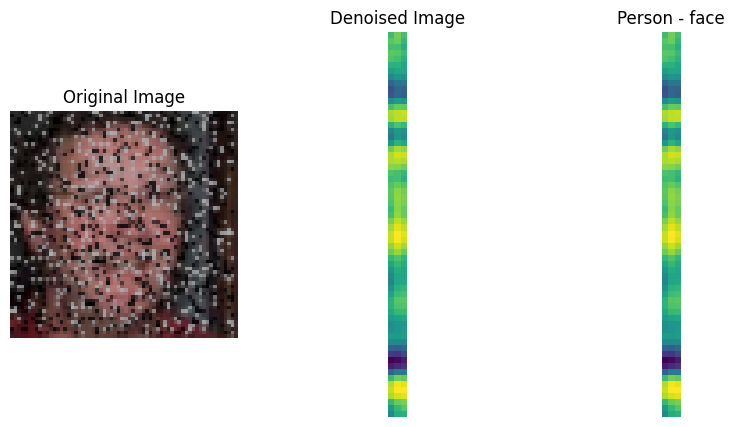

In [17]:
import os
import time
import numpy as np
import psutil
import onnxruntime as ort
from PIL import Image
import matplotlib.pyplot as plt
from memory_profiler import memory_usage

# Helper function to get storage size
def get_storage_size(file_path):
    if not os.path.exists(file_path):
        return 0.0
    return os.path.getsize(file_path) / (1024 * 1024)  # Size in MB

# Preprocess image
def preprocess_image(image_path, target_size=(64, 64)):
    img = Image.open(image_path).convert("RGB").resize(target_size)
    img = np.array(img, dtype=np.float32) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Helper function to measure inference
def measure_inference(func, *args):
    process = psutil.Process()
    start_time = time.time()
    start_cpu = process.cpu_percent(interval=None)
    mem_usage = memory_usage((func, args), interval=0.1, max_usage=True)
    result = func(*args)
    end_time = time.time()
    end_cpu = process.cpu_percent(interval=None)
    exec_time = (end_time - start_time) * 1000  # ms
    normalized_cpu = ((end_cpu + start_cpu) / 2) / psutil.cpu_count()  # Normalized to 0-100% of total capacity
    return mem_usage, normalized_cpu, exec_time, result

# Model and image paths
autoencoder_path = "/content/auto_16.onnx"
cnn_path = "/content/classifier_16.onnx"
input_image_path = "/content/test2.jpg"

# Label dictionary
label_dict = {0: "arm", 1: "elbow", 2: "face", 3: "foot", 4: "hand", 5: "leg", 6: "random"}

# Check storage
print("ONNX Storage (MB):")
print(f"AUTOENCODER: {get_storage_size(autoencoder_path):.2f}")
print(f"CNN: {get_storage_size(cnn_path):.2f}")
print()

# Load models
try:
    autoencoder_session = ort.InferenceSession(autoencoder_path, providers=['CPUExecutionProvider'])
    cnn_session = ort.InferenceSession(cnn_path, providers=['CPUExecutionProvider'])
    autoencoder_input_name = autoencoder_session.get_inputs()[0].name
    cnn_input_name = cnn_session.get_inputs()[0].name
except Exception as e:
    print(f"Failed to load models: {str(e)}")
    exit(1)

# Load image
try:
    input_image = preprocess_image(input_image_path)
except Exception as e:
    print(f"Failed to load image: {str(e)}")
    exit(1)

# Step 1: Denoising with Autoencoder
def autoencoder_inference():
    return autoencoder_session.run(None, {autoencoder_input_name: input_image})[0]

print("Autoencoder Inference Metrics (RAM in MB, CPU %, Execution Time in ms):")
try:
    auto_mem, auto_cpu, auto_time, denoised_image = measure_inference(autoencoder_inference)
    print(f"  RAM={auto_mem:.2f}, CPU={auto_cpu:.2f}%, Time={auto_time:.2f}ms")
except Exception as e:
    print(f"  Failed: {str(e)}")
    exit(1)
print()

# Convert output to image format
denoised_image = (denoised_image[0] * 255).astype(np.uint8)
denoised_pil = Image.fromarray(denoised_image)
denoised_pil.save("denoised_output_onnx.jpg")
print("? Denoised image saved: denoised_output_onnx.jpg")

# Step 2: Classification using CNN
def cnn_inference():
    denoised_input = denoised_image.astype(np.float32) / 255.0
    denoised_input = np.expand_dims(denoised_input, axis=0)
    return cnn_session.run(None, {cnn_input_name: denoised_input})[0]

print("CNN Inference Metrics (RAM in MB, CPU %, Execution Time in ms):")
try:
    cnn_mem, cnn_cpu, cnn_time, predictions = measure_inference(cnn_inference)
    print(f"  RAM={cnn_mem:.2f}, CPU={cnn_cpu:.2f}%, Time={cnn_time:.2f}ms")
except Exception as e:
    print(f"  Failed: {str(e)}")
    exit(1)
print()

# Get predicted class
predicted_class = np.argmax(predictions)
predicted_label = label_dict.get(predicted_class, "Unknown")
print(f"? Predicted Class: {predicted_label} (Class {predicted_class})")

# Plot results
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(input_image))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(denoised_pil)
plt.title("Denoised Image")
plt.axis('off')

display_text = "No person found" if predicted_label.lower() == "random" else f"Person - {predicted_label}"

plt.subplot(1, 3, 3)
plt.imshow(denoised_pil)
plt.title(display_text)
plt.axis('off')

plt.show()

ONNX Storage (MB):
AUTOENCODER: 0.29
CNN: 16.38

Autoencoder Inference Metrics (RAM in MB, CPU %, Execution Time in ms):
  RAM=264.16, CPU=14.00%, Time=303.55ms

? Denoised image saved: denoised_output_onnx.jpg
CNN Inference Metrics (RAM in MB, CPU %, Execution Time in ms):
  RAM=264.16, CPU=12.15%, Time=287.66ms

? Predicted Class: face (Class 2)


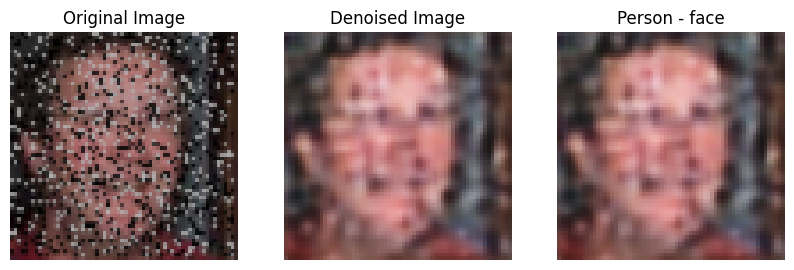

In [18]:
import os
import time
import numpy as np
import psutil
import onnxruntime as ort
from PIL import Image
import matplotlib.pyplot as plt
from memory_profiler import memory_usage

# Helper function to get storage size
def get_storage_size(file_path):
    if not os.path.exists(file_path):
        return 0.0
    return os.path.getsize(file_path) / (1024 * 1024)  # Size in MB

# Preprocess image
def preprocess_image(image_path, target_size=(64, 64)):
    img = Image.open(image_path).convert("RGB").resize(target_size)
    img = np.array(img, dtype=np.float32) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Helper function to measure inference
def measure_inference(func, *args):
    process = psutil.Process()
    start_time = time.time()
    start_cpu = process.cpu_percent(interval=None)
    mem_usage = memory_usage((func, args), interval=0.1, max_usage=True)
    result = func(*args)
    end_time = time.time()
    end_cpu = process.cpu_percent(interval=None)
    exec_time = (end_time - start_time) * 1000  # ms
    normalized_cpu = ((end_cpu + start_cpu) / 2) / psutil.cpu_count()  # Normalized to 0-100% of total capacity
    return mem_usage, normalized_cpu, exec_time, result

# Model and image paths
autoencoder_path = "/content/auto_static_int8.onnx"
cnn_path = "/content/classifier_static_int8.onnx"
input_image_path = "/content/test2.jpg"

# Label dictionary
label_dict = {0: "arm", 1: "elbow", 2: "face", 3: "foot", 4: "hand", 5: "leg", 6: "random"}

# Check storage
print("ONNX Storage (MB):")
print(f"AUTOENCODER: {get_storage_size(autoencoder_path):.2f}")
print(f"CNN: {get_storage_size(cnn_path):.2f}")
print()

# Load models
try:
    autoencoder_session = ort.InferenceSession(autoencoder_path, providers=['CPUExecutionProvider'])
    cnn_session = ort.InferenceSession(cnn_path, providers=['CPUExecutionProvider'])
    autoencoder_input_name = autoencoder_session.get_inputs()[0].name
    cnn_input_name = cnn_session.get_inputs()[0].name
except Exception as e:
    print(f"Failed to load models: {str(e)}")
    exit(1)

# Load image
try:
    input_image = preprocess_image(input_image_path)
except Exception as e:
    print(f"Failed to load image: {str(e)}")
    exit(1)

# Step 1: Denoising with Autoencoder
def autoencoder_inference():
    return autoencoder_session.run(None, {autoencoder_input_name: input_image})[0]

print("Autoencoder Inference Metrics (RAM in MB, CPU %, Execution Time in ms):")
try:
    auto_mem, auto_cpu, auto_time, denoised_image = measure_inference(autoencoder_inference)
    print(f"  RAM={auto_mem:.2f}, CPU={auto_cpu:.2f}%, Time={auto_time:.2f}ms")
except Exception as e:
    print(f"  Failed: {str(e)}")
    exit(1)
print()

# Convert output to image format
denoised_image = (denoised_image[0] * 255).astype(np.uint8)
denoised_pil = Image.fromarray(denoised_image)
denoised_pil.save("denoised_output_onnx.jpg")
print("? Denoised image saved: denoised_output_onnx.jpg")

# Step 2: Classification using CNN
def cnn_inference():
    denoised_input = denoised_image.astype(np.float32) / 255.0
    denoised_input = np.expand_dims(denoised_input, axis=0)
    return cnn_session.run(None, {cnn_input_name: denoised_input})[0]

print("CNN Inference Metrics (RAM in MB, CPU %, Execution Time in ms):")
try:
    cnn_mem, cnn_cpu, cnn_time, predictions = measure_inference(cnn_inference)
    print(f"  RAM={cnn_mem:.2f}, CPU={cnn_cpu:.2f}%, Time={cnn_time:.2f}ms")
except Exception as e:
    print(f"  Failed: {str(e)}")
    exit(1)
print()

# Get predicted class
predicted_class = np.argmax(predictions)
predicted_label = label_dict.get(predicted_class, "Unknown")
print(f"? Predicted Class: {predicted_label} (Class {predicted_class})")

# Plot results
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(input_image))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(denoised_pil)
plt.title("Denoised Image")
plt.axis('off')

display_text = "No person found" if predicted_label.lower() == "random" else f"Person - {predicted_label}"

plt.subplot(1, 3, 3)
plt.imshow(denoised_pil)
plt.title(display_text)
plt.axis('off')

plt.show()

ONNX Storage (MB):
AUTOENCODER: 0.09
CNN: 4.11

Failed to load models: [ONNXRuntimeError] : 9 : NOT_IMPLEMENTED : Could not find an implementation for ConvInteger(10) node with name 'functional_1/conv2d_1/BiasAdd_quant'
Autoencoder Inference Metrics (RAM in MB, CPU %, Execution Time in ms):
  RAM=265.11, CPU=12.35%, Time=80.92ms

? Denoised image saved: denoised_output_onnx.jpg
CNN Inference Metrics (RAM in MB, CPU %, Execution Time in ms):
  RAM=265.11, CPU=15.20%, Time=82.24ms

? Predicted Class: face (Class 2)


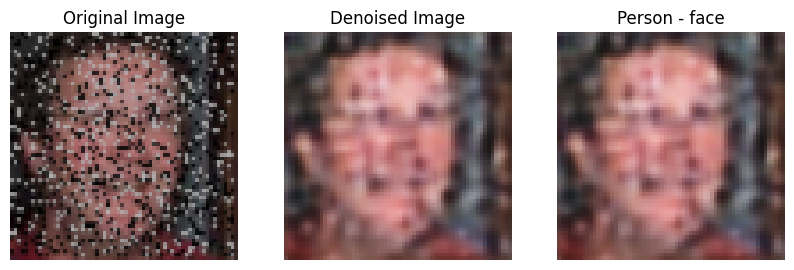

In [19]:
import os
import time
import numpy as np
import psutil
import onnxruntime as ort
from PIL import Image
import matplotlib.pyplot as plt
from memory_profiler import memory_usage

# Helper function to get storage size
def get_storage_size(file_path):
    if not os.path.exists(file_path):
        return 0.0
    return os.path.getsize(file_path) / (1024 * 1024)  # Size in MB

# Preprocess image
def preprocess_image(image_path, target_size=(64, 64)):
    img = Image.open(image_path).convert("RGB").resize(target_size)
    img = np.array(img, dtype=np.float32) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Helper function to measure inference
def measure_inference(func, *args):
    process = psutil.Process()
    start_time = time.time()
    start_cpu = process.cpu_percent(interval=None)
    mem_usage = memory_usage((func, args), interval=0.1, max_usage=True)
    result = func(*args)
    end_time = time.time()
    end_cpu = process.cpu_percent(interval=None)
    exec_time = (end_time - start_time) * 1000  # ms
    normalized_cpu = ((end_cpu + start_cpu) / 2) / psutil.cpu_count()  # Normalized to 0-100% of total capacity
    return mem_usage, normalized_cpu, exec_time, result

# Model and image paths
autoencoder_path = "/content/auto_int8.onnx"
cnn_path = "/content/classifier_int8.onnx"
input_image_path = "/content/test2.jpg"

# Label dictionary
label_dict = {0: "arm", 1: "elbow", 2: "face", 3: "foot", 4: "hand", 5: "leg", 6: "random"}

# Check storage
print("ONNX Storage (MB):")
print(f"AUTOENCODER: {get_storage_size(autoencoder_path):.2f}")
print(f"CNN: {get_storage_size(cnn_path):.2f}")
print()

# Load models
try:
    autoencoder_session = ort.InferenceSession(autoencoder_path, providers=['CPUExecutionProvider'])
    cnn_session = ort.InferenceSession(cnn_path, providers=['CPUExecutionProvider'])
    autoencoder_input_name = autoencoder_session.get_inputs()[0].name
    cnn_input_name = cnn_session.get_inputs()[0].name
except Exception as e:
    print(f"Failed to load models: {str(e)}")
    exit(1)

# Load image
try:
    input_image = preprocess_image(input_image_path)
except Exception as e:
    print(f"Failed to load image: {str(e)}")
    exit(1)

# Step 1: Denoising with Autoencoder
def autoencoder_inference():
    return autoencoder_session.run(None, {autoencoder_input_name: input_image})[0]

print("Autoencoder Inference Metrics (RAM in MB, CPU %, Execution Time in ms):")
try:
    auto_mem, auto_cpu, auto_time, denoised_image = measure_inference(autoencoder_inference)
    print(f"  RAM={auto_mem:.2f}, CPU={auto_cpu:.2f}%, Time={auto_time:.2f}ms")
except Exception as e:
    print(f"  Failed: {str(e)}")
    exit(1)
print()

# Convert output to image format
denoised_image = (denoised_image[0] * 255).astype(np.uint8)
denoised_pil = Image.fromarray(denoised_image)
denoised_pil.save("denoised_output_onnx.jpg")
print("? Denoised image saved: denoised_output_onnx.jpg")

# Step 2: Classification using CNN
def cnn_inference():
    denoised_input = denoised_image.astype(np.float32) / 255.0
    denoised_input = np.expand_dims(denoised_input, axis=0)
    return cnn_session.run(None, {cnn_input_name: denoised_input})[0]

print("CNN Inference Metrics (RAM in MB, CPU %, Execution Time in ms):")
try:
    cnn_mem, cnn_cpu, cnn_time, predictions = measure_inference(cnn_inference)
    print(f"  RAM={cnn_mem:.2f}, CPU={cnn_cpu:.2f}%, Time={cnn_time:.2f}ms")
except Exception as e:
    print(f"  Failed: {str(e)}")
    exit(1)
print()

# Get predicted class
predicted_class = np.argmax(predictions)
predicted_label = label_dict.get(predicted_class, "Unknown")
print(f"? Predicted Class: {predicted_label} (Class {predicted_class})")

# Plot results
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(input_image))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(denoised_pil)
plt.title("Denoised Image")
plt.axis('off')

display_text = "No person found" if predicted_label.lower() == "random" else f"Person - {predicted_label}"

plt.subplot(1, 3, 3)
plt.imshow(denoised_pil)
plt.title(display_text)
plt.axis('off')

plt.show()

ONNX Storage (MB):
AUTOENCODER: 0.15
CNN: 4.00

Failed to load models: [ONNXRuntimeError] : 7 : INVALID_PROTOBUF : Load model from /content/classifier_16_1.onnx failed:Protobuf parsing failed.
Autoencoder Inference Metrics (RAM in MB, CPU %, Execution Time in ms):
  RAM=265.13, CPU=17.25%, Time=86.92ms

? Denoised image saved: denoised_output_onnx.jpg
CNN Inference Metrics (RAM in MB, CPU %, Execution Time in ms):
  RAM=265.13, CPU=11.07%, Time=293.38ms

? Predicted Class: face (Class 2)


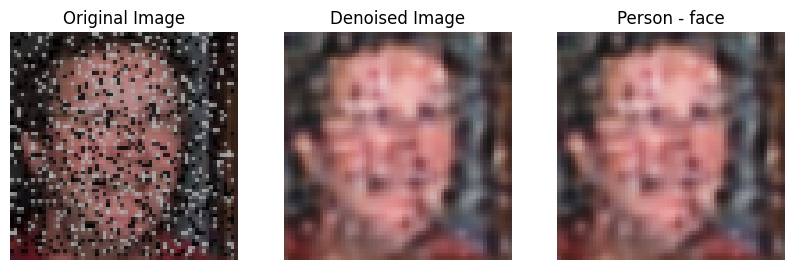

In [20]:
import os
import time
import numpy as np
import psutil
import onnxruntime as ort
from PIL import Image
import matplotlib.pyplot as plt
from memory_profiler import memory_usage

# Helper function to get storage size
def get_storage_size(file_path):
    if not os.path.exists(file_path):
        return 0.0
    return os.path.getsize(file_path) / (1024 * 1024)  # Size in MB

# Preprocess image
def preprocess_image(image_path, target_size=(64, 64)):
    img = Image.open(image_path).convert("RGB").resize(target_size)
    img = np.array(img, dtype=np.float32) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Helper function to measure inference
def measure_inference(func, *args):
    process = psutil.Process()
    start_time = time.time()
    start_cpu = process.cpu_percent(interval=None)
    mem_usage = memory_usage((func, args), interval=0.1, max_usage=True)
    result = func(*args)
    end_time = time.time()
    end_cpu = process.cpu_percent(interval=None)
    exec_time = (end_time - start_time) * 1000  # ms
    normalized_cpu = ((end_cpu + start_cpu) / 2) / psutil.cpu_count()  # Normalized to 0-100% of total capacity
    return mem_usage, normalized_cpu, exec_time, result

# Model and image paths
autoencoder_path = "/content/auto_16_1.onnx"
cnn_path = "/content/classifier_16_1.onnx"
input_image_path = "/content/test2.jpg"

# Label dictionary
label_dict = {0: "arm", 1: "elbow", 2: "face", 3: "foot", 4: "hand", 5: "leg", 6: "random"}

# Check storage
print("ONNX Storage (MB):")
print(f"AUTOENCODER: {get_storage_size(autoencoder_path):.2f}")
print(f"CNN: {get_storage_size(cnn_path):.2f}")
print()

# Load models
try:
    autoencoder_session = ort.InferenceSession(autoencoder_path, providers=['CPUExecutionProvider'])
    cnn_session = ort.InferenceSession(cnn_path, providers=['CPUExecutionProvider'])
    autoencoder_input_name = autoencoder_session.get_inputs()[0].name
    cnn_input_name = cnn_session.get_inputs()[0].name
except Exception as e:
    print(f"Failed to load models: {str(e)}")
    exit(1)

# Load image
try:
    input_image = preprocess_image(input_image_path)
except Exception as e:
    print(f"Failed to load image: {str(e)}")
    exit(1)

# Step 1: Denoising with Autoencoder
def autoencoder_inference():
    return autoencoder_session.run(None, {autoencoder_input_name: input_image})[0]

print("Autoencoder Inference Metrics (RAM in MB, CPU %, Execution Time in ms):")
try:
    auto_mem, auto_cpu, auto_time, denoised_image = measure_inference(autoencoder_inference)
    print(f"  RAM={auto_mem:.2f}, CPU={auto_cpu:.2f}%, Time={auto_time:.2f}ms")
except Exception as e:
    print(f"  Failed: {str(e)}")
    exit(1)
print()

# Convert output to image format
denoised_image = (denoised_image[0] * 255).astype(np.uint8)
denoised_pil = Image.fromarray(denoised_image)
denoised_pil.save("denoised_output_onnx.jpg")
print("? Denoised image saved: denoised_output_onnx.jpg")

# Step 2: Classification using CNN
def cnn_inference():
    denoised_input = denoised_image.astype(np.float32) / 255.0
    denoised_input = np.expand_dims(denoised_input, axis=0)
    return cnn_session.run(None, {cnn_input_name: denoised_input})[0]

print("CNN Inference Metrics (RAM in MB, CPU %, Execution Time in ms):")
try:
    cnn_mem, cnn_cpu, cnn_time, predictions = measure_inference(cnn_inference)
    print(f"  RAM={cnn_mem:.2f}, CPU={cnn_cpu:.2f}%, Time={cnn_time:.2f}ms")
except Exception as e:
    print(f"  Failed: {str(e)}")
    exit(1)
print()

# Get predicted class
predicted_class = np.argmax(predictions)
predicted_label = label_dict.get(predicted_class, "Unknown")
print(f"? Predicted Class: {predicted_label} (Class {predicted_class})")

# Plot results
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(input_image))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(denoised_pil)
plt.title("Denoised Image")
plt.axis('off')

display_text = "No person found" if predicted_label.lower() == "random" else f"Person - {predicted_label}"

plt.subplot(1, 3, 3)
plt.imshow(denoised_pil)
plt.title(display_text)
plt.axis('off')

plt.show()

ONNX Storage (MB):
AUTOENCODER: 0.09
CNN: 4.11

Failed to load models: [ONNXRuntimeError] : 9 : NOT_IMPLEMENTED : Could not find an implementation for ConvInteger(10) node with name 'functional_1/conv2d_1/BiasAdd_quant'
Autoencoder Inference Metrics (RAM in MB, CPU %, Execution Time in ms):
  RAM=265.16, CPU=11.22%, Time=155.79ms

✅ Denoised image saved: denoised_output_onnx.jpg
CNN Inference Metrics (RAM in MB, CPU %, Execution Time in ms):
  RAM=265.18, CPU=9.00%, Time=221.99ms

🔍 Predicted Class: face (Class 2)


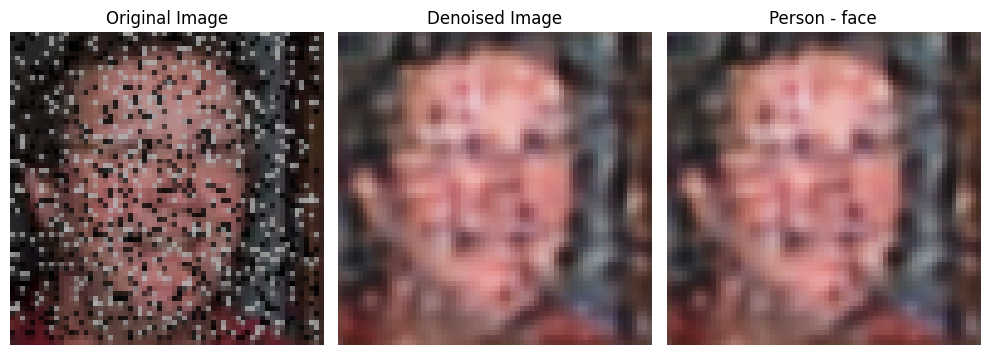

In [21]:
import os
import time
import numpy as np
import psutil
import onnxruntime as ort
from PIL import Image
import matplotlib.pyplot as plt
from memory_profiler import memory_usage

# Helper function to get storage size
def get_storage_size(file_path):
    if not os.path.exists(file_path):
        return 0.0
    return os.path.getsize(file_path) / (1024 * 1024)  # Size in MB

# Preprocess image
def preprocess_image(image_path, target_size=(64, 64)):
    img = Image.open(image_path).convert("RGB").resize(target_size)
    img = np.array(img, dtype=np.float32) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Helper function to measure inference
def measure_inference(func, *args):
    process = psutil.Process()
    start_time = time.time()
    start_cpu = process.cpu_percent(interval=None)
    mem_usage = memory_usage((func, args), interval=0.1, max_usage=True)
    result = func(*args)
    end_time = time.time()
    end_cpu = process.cpu_percent(interval=None)
    exec_time = (end_time - start_time) * 1000  # ms
    normalized_cpu = ((end_cpu + start_cpu) / 2) / psutil.cpu_count()  # Normalized to 0-100%
    return mem_usage, normalized_cpu, exec_time, result

# Paths
autoencoder_path = "/content/auto_int8.onnx"
cnn_path = "/content/classifier_int8.onnx"
input_image_path = "/content/test2.jpg"

# Labels
label_dict = {0: "arm", 1: "elbow", 2: "face", 3: "foot", 4: "hand", 5: "leg", 6: "random"}

# Print model sizes
print("ONNX Storage (MB):")
print(f"AUTOENCODER: {get_storage_size(autoencoder_path):.2f}")
print(f"CNN: {get_storage_size(cnn_path):.2f}")
print()

# Configure optimized session
def create_optimized_session(model_path):
    so = ort.SessionOptions()
    so.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL  # Use all optimization passes
    return ort.InferenceSession(model_path, sess_options=so, providers=['CPUExecutionProvider'])

# Load optimized models
try:
    autoencoder_session = create_optimized_session(autoencoder_path)
    cnn_session = create_optimized_session(cnn_path)
    autoencoder_input_name = autoencoder_session.get_inputs()[0].name
    cnn_input_name = cnn_session.get_inputs()[0].name
except Exception as e:
    print(f"Failed to load models: {str(e)}")
    exit(1)

# Preprocess input image
try:
    input_image = preprocess_image(input_image_path)
except Exception as e:
    print(f"Failed to load image: {str(e)}")
    exit(1)

# Autoencoder inference
def autoencoder_inference():
    return autoencoder_session.run(None, {autoencoder_input_name: input_image})[0]

print("Autoencoder Inference Metrics (RAM in MB, CPU %, Execution Time in ms):")
try:
    auto_mem, auto_cpu, auto_time, denoised_image = measure_inference(autoencoder_inference)
    print(f"  RAM={auto_mem:.2f}, CPU={auto_cpu:.2f}%, Time={auto_time:.2f}ms")
except Exception as e:
    print(f"  Failed: {str(e)}")
    exit(1)
print()

# Convert and save denoised output
denoised_image = (denoised_image[0] * 255).astype(np.uint8)
denoised_pil = Image.fromarray(denoised_image)
denoised_pil.save("denoised_output_onnx.jpg")
print("✅ Denoised image saved: denoised_output_onnx.jpg")

# CNN inference
def cnn_inference():
    denoised_input = denoised_image.astype(np.float32) / 255.0
    denoised_input = np.expand_dims(denoised_input, axis=0)
    return cnn_session.run(None, {cnn_input_name: denoised_input})[0]

print("CNN Inference Metrics (RAM in MB, CPU %, Execution Time in ms):")
try:
    cnn_mem, cnn_cpu, cnn_time, predictions = measure_inference(cnn_inference)
    print(f"  RAM={cnn_mem:.2f}, CPU={cnn_cpu:.2f}%, Time={cnn_time:.2f}ms")
except Exception as e:
    print(f"  Failed: {str(e)}")
    exit(1)
print()

# Prediction
predicted_class = int(np.argmax(predictions))
predicted_label = label_dict.get(predicted_class, "Unknown")
print(f"🔍 Predicted Class: {predicted_label} (Class {predicted_class})")

# Plot results
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(input_image))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(denoised_pil)
plt.title("Denoised Image")
plt.axis('off')

display_text = "No person found" if predicted_label.lower() == "random" else f"Person - {predicted_label}"
plt.subplot(1, 3, 3)
plt.imshow(denoised_pil)
plt.title(display_text)
plt.axis('off')

plt.tight_layout()
plt.show()


ONNX Storage (MB):
AUTOENCODER: 0.29
CNN: 16.38

Autoencoder Inference Metrics (RAM in MB, CPU %, Execution Time in ms):
  RAM=266.28, CPU=11.40%, Time=263.17ms

✅ Denoised image saved: denoised_output_onnx.jpg
CNN Inference Metrics (RAM in MB, CPU %, Execution Time in ms):
  RAM=266.28, CPU=10.70%, Time=280.12ms

🔍 Predicted Class: face (Class 2)


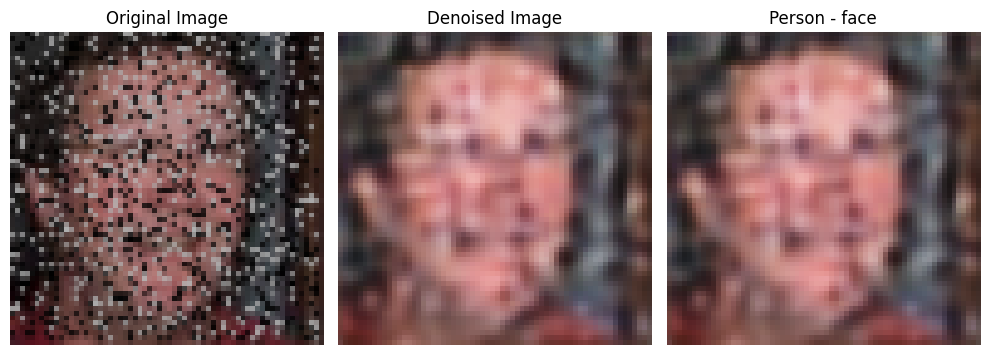

In [22]:
import os
import time
import numpy as np
import psutil
import onnxruntime as ort
from PIL import Image
import matplotlib.pyplot as plt
from memory_profiler import memory_usage

# Helper function to get storage size
def get_storage_size(file_path):
    if not os.path.exists(file_path):
        return 0.0
    return os.path.getsize(file_path) / (1024 * 1024)  # Size in MB

# Preprocess image
def preprocess_image(image_path, target_size=(64, 64)):
    img = Image.open(image_path).convert("RGB").resize(target_size)
    img = np.array(img, dtype=np.float32) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Helper function to measure inference
def measure_inference(func, *args):
    process = psutil.Process()
    start_time = time.time()
    start_cpu = process.cpu_percent(interval=None)
    mem_usage = memory_usage((func, args), interval=0.1, max_usage=True)
    result = func(*args)
    end_time = time.time()
    end_cpu = process.cpu_percent(interval=None)
    exec_time = (end_time - start_time) * 1000  # ms
    normalized_cpu = ((end_cpu + start_cpu) / 2) / psutil.cpu_count()  # Normalized to 0-100%
    return mem_usage, normalized_cpu, exec_time, result

# Paths
autoencoder_path = "/content/autoencoder_model.onnx"
cnn_path = "/content/cnn_model.onnx"
input_image_path = "/content/test2.jpg"

# Labels
label_dict = {0: "arm", 1: "elbow", 2: "face", 3: "foot", 4: "hand", 5: "leg", 6: "random"}

# Print model sizes
print("ONNX Storage (MB):")
print(f"AUTOENCODER: {get_storage_size(autoencoder_path):.2f}")
print(f"CNN: {get_storage_size(cnn_path):.2f}")
print()

# Configure optimized session
def create_optimized_session(model_path):
    so = ort.SessionOptions()
    so.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL  # Use all optimization passes
    return ort.InferenceSession(model_path, sess_options=so, providers=['CPUExecutionProvider'])

# Load optimized models
try:
    autoencoder_session = create_optimized_session(autoencoder_path)
    cnn_session = create_optimized_session(cnn_path)
    autoencoder_input_name = autoencoder_session.get_inputs()[0].name
    cnn_input_name = cnn_session.get_inputs()[0].name
except Exception as e:
    print(f"Failed to load models: {str(e)}")
    exit(1)

# Preprocess input image
try:
    input_image = preprocess_image(input_image_path)
except Exception as e:
    print(f"Failed to load image: {str(e)}")
    exit(1)

# Autoencoder inference
def autoencoder_inference():
    return autoencoder_session.run(None, {autoencoder_input_name: input_image})[0]

print("Autoencoder Inference Metrics (RAM in MB, CPU %, Execution Time in ms):")
try:
    auto_mem, auto_cpu, auto_time, denoised_image = measure_inference(autoencoder_inference)
    print(f"  RAM={auto_mem:.2f}, CPU={auto_cpu:.2f}%, Time={auto_time:.2f}ms")
except Exception as e:
    print(f"  Failed: {str(e)}")
    exit(1)
print()

# Convert and save denoised output
denoised_image = (denoised_image[0] * 255).astype(np.uint8)
denoised_pil = Image.fromarray(denoised_image)
denoised_pil.save("denoised_output_onnx.jpg")
print("✅ Denoised image saved: denoised_output_onnx.jpg")

# CNN inference
def cnn_inference():
    denoised_input = denoised_image.astype(np.float32) / 255.0
    denoised_input = np.expand_dims(denoised_input, axis=0)
    return cnn_session.run(None, {cnn_input_name: denoised_input})[0]

print("CNN Inference Metrics (RAM in MB, CPU %, Execution Time in ms):")
try:
    cnn_mem, cnn_cpu, cnn_time, predictions = measure_inference(cnn_inference)
    print(f"  RAM={cnn_mem:.2f}, CPU={cnn_cpu:.2f}%, Time={cnn_time:.2f}ms")
except Exception as e:
    print(f"  Failed: {str(e)}")
    exit(1)
print()

# Prediction
predicted_class = int(np.argmax(predictions))
predicted_label = label_dict.get(predicted_class, "Unknown")
print(f"🔍 Predicted Class: {predicted_label} (Class {predicted_class})")

# Plot results
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(input_image))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(denoised_pil)
plt.title("Denoised Image")
plt.axis('off')

display_text = "No person found" if predicted_label.lower() == "random" else f"Person - {predicted_label}"
plt.subplot(1, 3, 3)
plt.imshow(denoised_pil)
plt.title(display_text)
plt.axis('off')

plt.tight_layout()
plt.show()


ONNX Storage (MB):
AUTOENCODER: 0.29
CNN: 16.38

Autoencoder Inference Metrics (RAM in MB, CPU %, Execution Time in ms):
  RAM=266.82, CPU=16.23%, Time=76.98ms

✅ Denoised image saved: denoised_output_onnx.jpg
CNN Inference Metrics (RAM in MB, CPU %, Execution Time in ms):
  RAM=266.95, CPU=16.20%, Time=77.17ms

🔍 Predicted Class: face (Class 2)


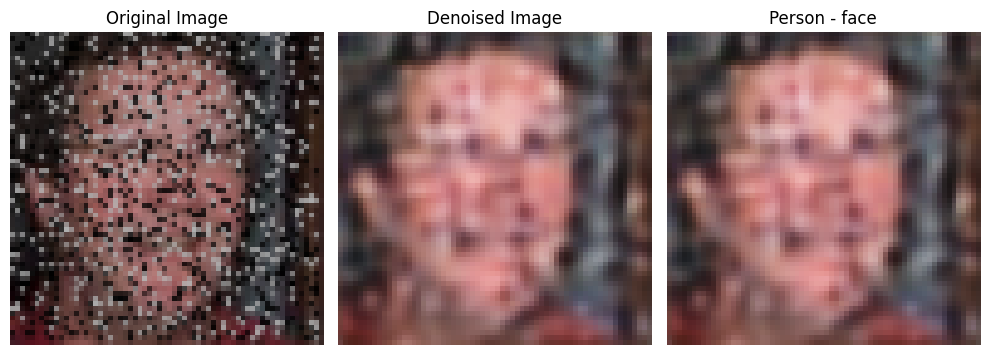

In [23]:
import os
import time
import numpy as np
import psutil
import onnxruntime as ort
from PIL import Image
import matplotlib.pyplot as plt
from memory_profiler import memory_usage

# Helper function to get storage size
def get_storage_size(file_path):
    if not os.path.exists(file_path):
        return 0.0
    return os.path.getsize(file_path) / (1024 * 1024)  # Size in MB

# Preprocess image
def preprocess_image(image_path, target_size=(64, 64)):
    img = Image.open(image_path).convert("RGB").resize(target_size)
    img = np.array(img, dtype=np.float32) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Helper function to measure inference
def measure_inference(func, *args):
    process = psutil.Process()
    start_time = time.time()
    start_cpu = process.cpu_percent(interval=None)
    mem_usage = memory_usage((func, args), interval=0.1, max_usage=True)
    result = func(*args)
    end_time = time.time()
    end_cpu = process.cpu_percent(interval=None)
    exec_time = (end_time - start_time) * 1000  # ms
    normalized_cpu = ((end_cpu + start_cpu) / 2) / psutil.cpu_count()  # Normalized to 0-100%
    return mem_usage, normalized_cpu, exec_time, result

# Paths
autoencoder_path = "/content/auto_static_int8.onnx"
cnn_path = "/content/classifier_static_int8.onnx"
input_image_path = "/content/test2.jpg"

# Labels
label_dict = {0: "arm", 1: "elbow", 2: "face", 3: "foot", 4: "hand", 5: "leg", 6: "random"}

# Print model sizes
print("ONNX Storage (MB):")
print(f"AUTOENCODER: {get_storage_size(autoencoder_path):.2f}")
print(f"CNN: {get_storage_size(cnn_path):.2f}")
print()

# Configure optimized session
def create_optimized_session(model_path):
    so = ort.SessionOptions()
    so.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL  # Use all optimization passes
    return ort.InferenceSession(model_path, sess_options=so, providers=['CPUExecutionProvider'])

# Load optimized models
try:
    autoencoder_session = create_optimized_session(autoencoder_path)
    cnn_session = create_optimized_session(cnn_path)
    autoencoder_input_name = autoencoder_session.get_inputs()[0].name
    cnn_input_name = cnn_session.get_inputs()[0].name
except Exception as e:
    print(f"Failed to load models: {str(e)}")
    exit(1)

# Preprocess input image
try:
    input_image = preprocess_image(input_image_path)
except Exception as e:
    print(f"Failed to load image: {str(e)}")
    exit(1)

# Autoencoder inference
def autoencoder_inference():
    return autoencoder_session.run(None, {autoencoder_input_name: input_image})[0]

print("Autoencoder Inference Metrics (RAM in MB, CPU %, Execution Time in ms):")
try:
    auto_mem, auto_cpu, auto_time, denoised_image = measure_inference(autoencoder_inference)
    print(f"  RAM={auto_mem:.2f}, CPU={auto_cpu:.2f}%, Time={auto_time:.2f}ms")
except Exception as e:
    print(f"  Failed: {str(e)}")
    exit(1)
print()

# Convert and save denoised output
denoised_image = (denoised_image[0] * 255).astype(np.uint8)
denoised_pil = Image.fromarray(denoised_image)
denoised_pil.save("denoised_output_onnx.jpg")
print("✅ Denoised image saved: denoised_output_onnx.jpg")

# CNN inference
def cnn_inference():
    denoised_input = denoised_image.astype(np.float32) / 255.0
    denoised_input = np.expand_dims(denoised_input, axis=0)
    return cnn_session.run(None, {cnn_input_name: denoised_input})[0]

print("CNN Inference Metrics (RAM in MB, CPU %, Execution Time in ms):")
try:
    cnn_mem, cnn_cpu, cnn_time, predictions = measure_inference(cnn_inference)
    print(f"  RAM={cnn_mem:.2f}, CPU={cnn_cpu:.2f}%, Time={cnn_time:.2f}ms")
except Exception as e:
    print(f"  Failed: {str(e)}")
    exit(1)
print()

# Prediction
predicted_class = int(np.argmax(predictions))
predicted_label = label_dict.get(predicted_class, "Unknown")
print(f"🔍 Predicted Class: {predicted_label} (Class {predicted_class})")

# Plot results
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(input_image))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(denoised_pil)
plt.title("Denoised Image")
plt.axis('off')

display_text = "No person found" if predicted_label.lower() == "random" else f"Person - {predicted_label}"
plt.subplot(1, 3, 3)
plt.imshow(denoised_pil)
plt.title(display_text)
plt.axis('off')

plt.tight_layout()
plt.show()


ONNX Storage (MB):
AUTOENCODER: 0.15
CNN: 8.19

Autoencoder Inference Metrics (RAM in MB, CPU %, Execution Time in ms):
  RAM=267.77, CPU=16.20%, Time=92.48ms

✅ Denoised image saved: denoised_output_onnx.jpg
CNN Inference Metrics (RAM in MB, CPU %, Execution Time in ms):
  Failed: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Unexpected input data type. Actual: (tensor(float)) , expected: (tensor(float16))

🔍 Predicted Class: face (Class 2)


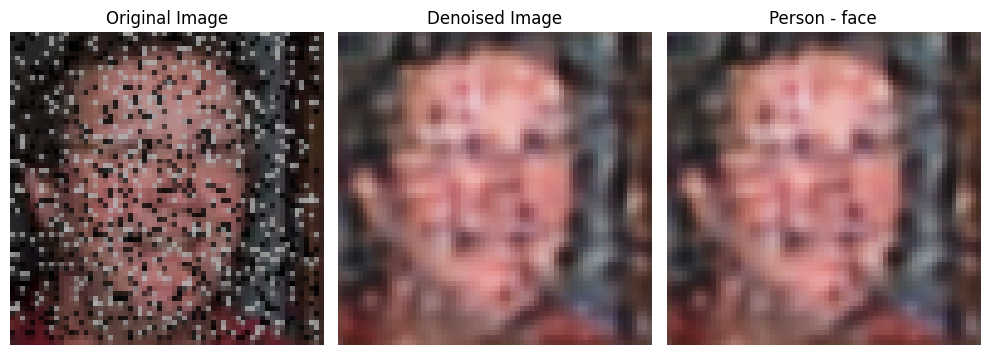

In [24]:
import os
import time
import numpy as np
import psutil
import onnxruntime as ort
from PIL import Image
import matplotlib.pyplot as plt
from memory_profiler import memory_usage

# Helper function to get storage size
def get_storage_size(file_path):
    if not os.path.exists(file_path):
        return 0.0
    return os.path.getsize(file_path) / (1024 * 1024)  # Size in MB

# Preprocess image
def preprocess_image(image_path, target_size=(64, 64)):
    img = Image.open(image_path).convert("RGB").resize(target_size)
    img = np.array(img, dtype=np.float32) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Helper function to measure inference
def measure_inference(func, *args):
    process = psutil.Process()
    start_time = time.time()
    start_cpu = process.cpu_percent(interval=None)
    mem_usage = memory_usage((func, args), interval=0.1, max_usage=True)
    result = func(*args)
    end_time = time.time()
    end_cpu = process.cpu_percent(interval=None)
    exec_time = (end_time - start_time) * 1000  # ms
    normalized_cpu = ((end_cpu + start_cpu) / 2) / psutil.cpu_count()  # Normalized to 0-100%
    return mem_usage, normalized_cpu, exec_time, result

# Paths
autoencoder_path = "/content/auto_16_1.onnx"
cnn_path = "/content/classifier_16_1.onnx"
input_image_path = "/content/test2.jpg"

# Labels
label_dict = {0: "arm", 1: "elbow", 2: "face", 3: "foot", 4: "hand", 5: "leg", 6: "random"}

# Print model sizes
print("ONNX Storage (MB):")
print(f"AUTOENCODER: {get_storage_size(autoencoder_path):.2f}")
print(f"CNN: {get_storage_size(cnn_path):.2f}")
print()

# Configure optimized session
def create_optimized_session(model_path):
    so = ort.SessionOptions()
    so.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL  # Use all optimization passes
    return ort.InferenceSession(model_path, sess_options=so, providers=['CPUExecutionProvider'])

# Load optimized models
try:
    autoencoder_session = create_optimized_session(autoencoder_path)
    cnn_session = create_optimized_session(cnn_path)
    autoencoder_input_name = autoencoder_session.get_inputs()[0].name
    cnn_input_name = cnn_session.get_inputs()[0].name
except Exception as e:
    print(f"Failed to load models: {str(e)}")
    exit(1)

# Preprocess input image
try:
    input_image = preprocess_image(input_image_path)
except Exception as e:
    print(f"Failed to load image: {str(e)}")
    exit(1)

# Autoencoder inference
def autoencoder_inference():
    return autoencoder_session.run(None, {autoencoder_input_name: input_image})[0]

print("Autoencoder Inference Metrics (RAM in MB, CPU %, Execution Time in ms):")
try:
    auto_mem, auto_cpu, auto_time, denoised_image = measure_inference(autoencoder_inference)
    print(f"  RAM={auto_mem:.2f}, CPU={auto_cpu:.2f}%, Time={auto_time:.2f}ms")
except Exception as e:
    print(f"  Failed: {str(e)}")
    exit(1)
print()

# Convert and save denoised output
denoised_image = (denoised_image[0] * 255).astype(np.uint8)
denoised_pil = Image.fromarray(denoised_image)
denoised_pil.save("denoised_output_onnx.jpg")
print("✅ Denoised image saved: denoised_output_onnx.jpg")

# CNN inference
def cnn_inference():
    denoised_input = denoised_image.astype(np.float32) / 255.0
    denoised_input = np.expand_dims(denoised_input, axis=0)
    return cnn_session.run(None, {cnn_input_name: denoised_input})[0]

print("CNN Inference Metrics (RAM in MB, CPU %, Execution Time in ms):")
try:
    cnn_mem, cnn_cpu, cnn_time, predictions = measure_inference(cnn_inference)
    print(f"  RAM={cnn_mem:.2f}, CPU={cnn_cpu:.2f}%, Time={cnn_time:.2f}ms")
except Exception as e:
    print(f"  Failed: {str(e)}")
    exit(1)
print()

# Prediction
predicted_class = int(np.argmax(predictions))
predicted_label = label_dict.get(predicted_class, "Unknown")
print(f"🔍 Predicted Class: {predicted_label} (Class {predicted_class})")

# Plot results
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(input_image))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(denoised_pil)
plt.title("Denoised Image")
plt.axis('off')

display_text = "No person found" if predicted_label.lower() == "random" else f"Person - {predicted_label}"
plt.subplot(1, 3, 3)
plt.imshow(denoised_pil)
plt.title(display_text)
plt.axis('off')

plt.tight_layout()
plt.show()
